In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from backtesting import Backtest, Strategy
from datetime import datetime

Initial data fetching

In [2]:
df = yf.download("AAPL")
df = df.loc['2016-12-08':,:]
df['change_tomorrow'] = df.Close.pct_change(-1) * 100 * -1
df = df.dropna().copy()
df['change_tomorrow_direction'] = np.where(df.change_tomorrow > 0, 'Up', 'Down')
df.head()

[*********************100%***********************]  1 of 1 completed
/var/folders/33/_ft973790qv2wpzyrpc3p2fr0000gn/T/ipykernel_28227/1608647609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change_tomorrow'] = df.Close.pct_change(-1) * 100 * -1


,Open,High,Low,Close,Adj Close,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,,
2016-12-08,27.715000,28.107500,27.650000,28.030001,25.987461,108273200,1.605962,Up
2016-12-09,28.077499,28.674999,28.077499,28.487499,26.411621,137610400,-0.573693,Down
2016-12-12,28.322500,28.750000,28.122499,28.325001,26.260971,105497600,1.640767,Up
2016-12-13,28.459999,28.980000,28.437500,28.797501,26.699034,174935200,-0.000000,Down
2016-12-14,28.760000,29.049999,28.745001,28.797501,26.699034,136127200,0.543945,Up


In [3]:
target = df.change_tomorrow_direction
explanatory = df.drop(columns=['change_tomorrow', 'change_tomorrow_direction', 'Adj Close'])
explanatory.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-12-08,27.715000,28.107500,27.650000,28.030001,108273200
2016-12-09,28.077499,28.674999,28.077499,28.487499,137610400
2016-12-12,28.322500,28.750000,28.122499,28.325001,105497600
2016-12-13,28.459999,28.980000,28.437500,28.797501,174935200
2016-12-14,28.760000,29.049999,28.745001,28.797501,136127200


[Text(0.13044339503042596, 0.96875, 'Volume <= 37274950.0\ngini = 0.497\nsamples = 1961\nvalue = [909, 1052]'),
 Text(0.0486815415821501, 0.90625, 'Open <= 226.64\ngini = 0.36\nsamples = 17\nvalue = [13, 4]'),
 Text(0.08956246830628803, 0.9375, 'True  '),
 Text(0.04056795131845842, 0.84375, 'High <= 221.67\ngini = 0.305\nsamples = 16\nvalue = [13, 3]'),
 Text(0.032454361054766734, 0.78125, 'Low <= 205.515\ngini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(0.02434077079107505, 0.71875, 'Open <= 193.695\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.016227180527383367, 0.65625, 'Close <= 189.975\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.008113590263691683, 0.59375, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.02434077079107505, 0.59375, 'Low <= 189.155\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.016227180527383367, 0.53125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.032454361054766734, 0.53125, 'Close <= 191.975\ngini = 0.5\nsamples = 2\nval

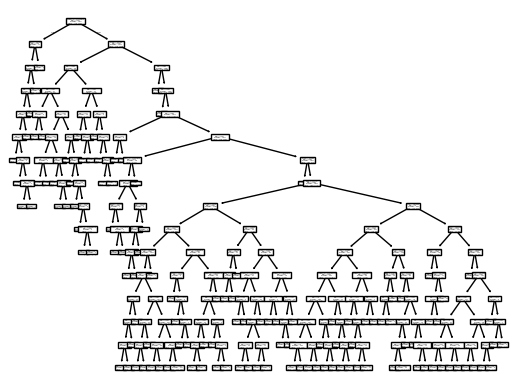

In [4]:
model_dt = DecisionTreeClassifier(max_depth=15)
model_dt.fit(X=explanatory,y=target)

plot_tree(decision_tree=model_dt, feature_names=model_dt.feature_names_in_)

In [5]:
y_pred = model_dt.predict(X=explanatory)
df_predictions = df[['change_tomorrow_direction']].copy()
df_predictions['predictions'] = y_pred
df_predictions

,change_tomorrow_direction,predictions
Date,,
2016-12-08,Up,Up
2016-12-09,Down,Down
2016-12-12,Up,Up
2016-12-13,Down,Down
2016-12-14,Up,Up
...,...,...
2024-09-19,Down,Down
2024-09-20,Down,Down
2024-09-23,Up,Up


In [6]:
comp = df_predictions.change_tomorrow_direction == df_predictions.predictions
model_accuracy = model_dt.score(X=explanatory, y=target)
model_accuracy

0.6583375828658847

In [7]:
class ClassificationUp(Strategy):  
    def init(self):
        self.model = model_dt 
        self.already_bought = False

    def next(self):
        latest_data = {
            'Open': self.data.Open[-1],
            'High': self.data.High[-1],
            'Low': self.data.Low[-1],
            'Close': self.data.Close[-1],
            'Volume': self.data.Volume[-1]
        }
        explanatory_today = pd.DataFrame([latest_data])
        
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow == 'Up' and not self.already_bought:  
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == 'Down' and self.already_bought:  
            self.sell()
            self.already_bought = False

In [8]:
bt = Backtest(explanatory, ClassificationUp, cash=10000, commission=0.002, exclusive_orders=True) 
stats = bt.run()
stats

Start                     2016-12-08 00:00:00
End                       2024-09-25 00:00:00
Duration                   2848 days 00:00:00
Exposure Time [%]                   99.847017
Equity Final [$]                922061.879179
Equity Peak [$]                 948070.286979
Return [%]                        9120.618792
Buy & Hold Return [%]              707.598964
Return (Ann.) [%]                   78.847631
Volatility (Ann.) [%]               53.114139
Sharpe Ratio                         1.484494
Sortino Ratio                        4.060399
Calmar Ratio                         1.903374
Max. Drawdown [%]                   -41.42518
Avg. Drawdown [%]                   -3.462271
Max. Drawdown Duration      446 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                  379
Win Rate [%]                        67.282322
Best Trade [%]                     236.454188
Worst Trade [%]                    -16.235945
Avg. Trade [%]                    